# Estimating Covariance and Expected Returns

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('C:/Users/Wazir')
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2


In [2]:

inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
#inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="ew", n_inds=49)["1974":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["1974":]

In [5]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.133872,0.187733,-0.613456,6.736417,0.082009,0.122226,0.538298,-0.59806
CW,0.133744,0.187514,-0.542993,5.793708,0.081947,0.120151,0.538266,-0.58785


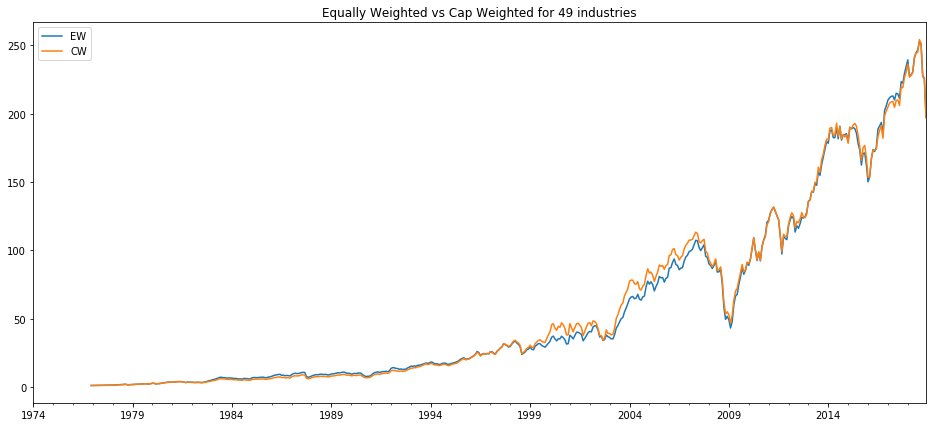

In [7]:
btr = pd.DataFrame({'EW': ewr, 
                    'CW': cwr})
(1+btr).cumprod().plot(figsize=(16,7), title= 'Equally Weighted vs Cap Weighted for 49 industries')
erk.summary_stats(btr.dropna())

## Global Minimum Variance Portfolio

In [8]:
def sample_cov(r, **kwargs):
    
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    
    est_cov = cov_estimator(r, **kwargs)
    return erk.gmv(est_cov)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.133872,0.187733,-0.613456,6.736417,0.082009,0.122226,0.538298,-0.598060
CW,0.133744,0.187514,-0.542993,5.793708,0.081947,0.120151,0.538266,-0.587850
GMV-Sample,0.159491,0.097030,-0.530876,5.054834,0.036142,0.055959,1.298909,-0.332077


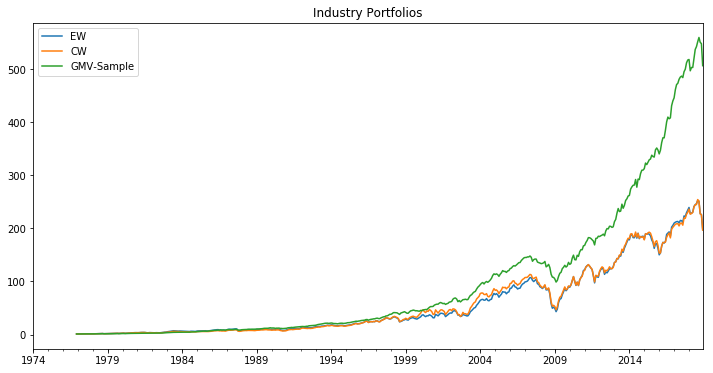

In [9]:
mv_s_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Now, let's try a new estimator - Constant Correlation. The idea is simple, take the sample correlation matrix, compute the average correlation and then reconstruct the covariance matrix. The relation between correlations $\rho$ and covariance $\sigma$ is given by:

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$


In [23]:
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    
    """
    rhos = r.cov()
    n = rhos.shape[0]
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1)
    sd = r.std()
    
    ccov = ccor *np.outer(sd,sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)    

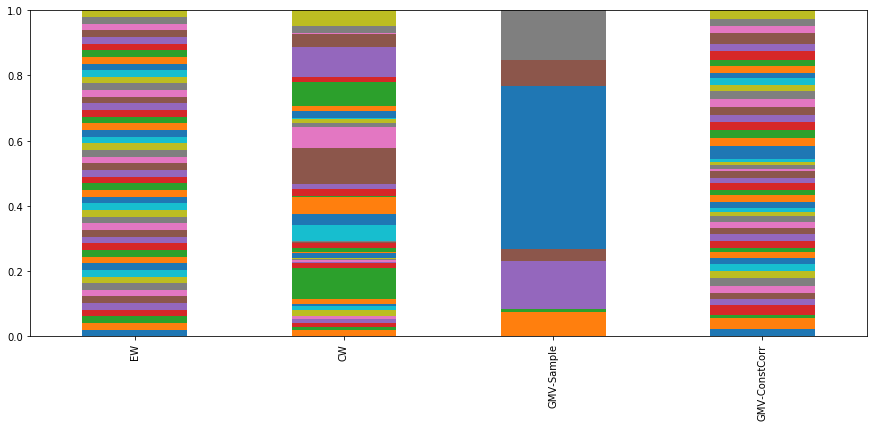

In [24]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(ind_rets["2016":]),
    "CW": erk.weight_cw(ind_rets["2016":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_rets["2016":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_rets["2016":], cov_estimator=cc_cov),
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=False);


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.133872,0.187733,-0.613456,6.736417,0.082009,0.122226,0.538298,-0.598060
CW,0.133744,0.187514,-0.542993,5.793708,0.081947,0.120151,0.538266,-0.587850
GMV-Sample,0.159491,0.097030,-0.530876,5.054834,0.036142,0.055959,1.298909,-0.332077
GMV-CC,0.135279,0.173611,-0.770486,6.999891,0.076809,0.114312,0.590015,-0.584922


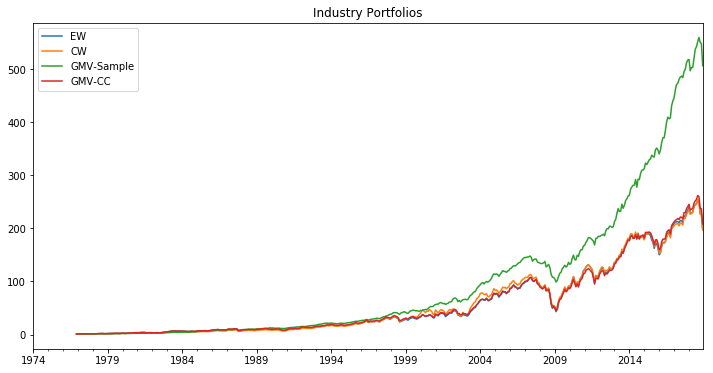

In [25]:
mv_cc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=cc_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

### Statistical Shrinkage

We can mix the model and sample estimates by choosing a shrinkage parameter. You can either let the numbers dictate an optimal shrinkage value for $\delta$ although in practice many practitioners choose $0.5$. Let's implement a simple shrinkage based covariance estimator that shrinks towards the Constant Correlation estimate.

In [26]:
def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

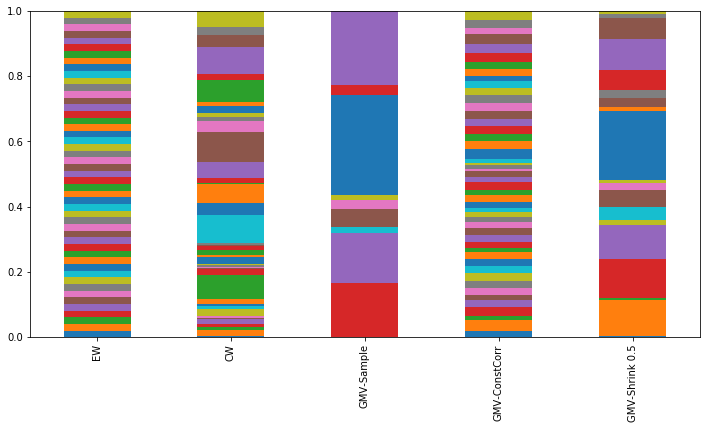

In [27]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(ind_rets["2013":]),
    "CW": erk.weight_cw(ind_rets["2013":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_rets["2013":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_rets["2013":], cov_estimator=cc_cov),
    "GMV-Shrink 0.5": weight_gmv(ind_rets["2013":], cov_estimator=shrinkage_cov),
})
wts.T.plot.bar(stacked=True, figsize=(12,6), legend=False);


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.133872,0.187733,-0.613456,6.736417,0.082009,0.122226,0.538298,-0.598060
CW,0.133744,0.187514,-0.542993,5.793708,0.081947,0.120151,0.538266,-0.587850
GMV-Sample,0.159491,0.097030,-0.530876,5.054834,0.036142,0.055959,1.298909,-0.332077
GMV-CC,0.135279,0.173611,-0.770486,6.999891,0.076809,0.114312,0.590015,-0.584922
GMV-Shrink 0.5,0.155823,0.103791,-0.880396,6.392351,0.041648,0.064159,1.179877,-0.374984


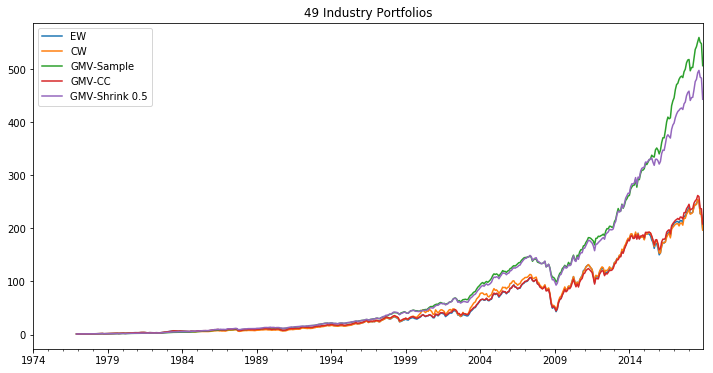

In [28]:
mv_sh_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.5)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, 'GMV-Shrink 0.5': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="49 Industry Portfolios")
erk.summary_stats(btr.dropna())